In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import meteostat as mt
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import griddata
from metpy.interpolate import interpolate_to_grid


# Setup

In [2]:
# set your domain, lon_min, lon_max, lat_min, lat_max
DOMAIN = [-80, -25, -60, 15]

# set your horizontal resolution in degrees
RES = 0.25

# set variables list
variables = ['tmax', 'tmin']

# set your start and end date
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 1, 1)

# set interpolation kwargs
interpol_kwargs = {
    "interp_type": "cressman",
    "minimum_neighbors": 2,
    "search_radius": 10,
    "hres": RES
}

# if true the lapse rate will be applied to make interpolate all station in the same altitude level
TEMPERATURE_VARS = True

# dry adiabatic lapse rate (9.8 °C/km)
LAPSE_RATE = 9.8 

# set engine to handle with netcdf files
nc_engine = 'xarray'  # options 'netcdf4' and 'xarray'

# Checkings

In [3]:
NC_ENGINE = nc_engine.lower()  # avoid upper case errors
VARIABLES = [variables] if not isinstance(variables, list) else variables  # check right type

if NC_ENGINE not in ['netcdf4', 'xarray']:
    raise ValueError(f"invalid NC_ENGINE @ {NC_ENGINE} choose 'xarray' or 'netcdf4'")
    

# Check DOMAIN
if DOMAIN[0] >= DOMAIN[1]:
    raise ValueError(f"invalid domain, initial longitude {DOMAIN[0]} must be lower than final one {DOMAIN[1]}")
    
if DOMAIN[2] >= DOMAIN[3]:
    raise ValueError(f"invalid domain, initial latitude {DOMAIN[2]} must be lower than final one {DOMAIN[3]}")
    
if RES <= 0:
    raise ValueError(f"invalid resolution, resolution must be higher than 0, {RES} passed")
    
# Check date
if START_DATE > END_DATE:
    raise ValueError(f"invalid date definition, start date {START_DATE} must be higher or equal end date {END_DATE}")
    
    
# Check if variables are defined
if not VARIABLES:
    raise ValueError(f"VARIABLES must be defined")

# Pre-processing

In [4]:
# set interpolated grid parameters
grid_lat = np.arange(DOMAIN[-2], DOMAIN[-1] + RES, RES)
grid_lon = np.arange(DOMAIN[0], DOMAIN[1] + RES, RES)

dates = pd.date_range(start=START_DATE, end=END_DATE, freq='1D').to_pydatetime()

boundary_coords = {
        'west': grid_lon.min(),
        'south': grid_lat.min(),
        'east': grid_lon.max(),
        'north': grid_lat.max()
    }

interpol_kwargs.update(dict(boundary_coords=boundary_coords))
interpol_kwargs

{'interp_type': 'cressman',
 'minimum_neighbors': 2,
 'search_radius': 10,
 'hres': 0.25,
 'boundary_coords': {'west': -80.0,
  'south': -60.0,
  'east': -25.0,
  'north': 15.0}}

# Getting stations file

For educational purposes, we will use Meteostat to retrieve data from weather stations; any other CSV file can be used as long as it follows the same format.

It must be station (id or name), latitude, longitude and elevation columns, the column(s) with VARIABLES defined in setup is necessary as well

In [5]:

# set specified domain to get weather station data, format (domain_top, domain_left), (domain_bottom, domain_right)
stations = mt.Stations().bounds((DOMAIN[-1], DOMAIN[0]), (DOMAIN[2], DOMAIN[1])).fetch()

station_df = []

# loop into all stations
for station_id, row in stations.iterrows():
    
    # get data for specified period
    data = mt.Daily(station_id, start=START_DATE, end=END_DATE).fetch()
    
    # include weather station info
    data['station'] = station_id
    data['latitude'] = row.latitude
    data['longitude'] = row.longitude
    data['elevation'] = row.elevation
    
    # append DataFrame to current weather station
    station_df.append(data)
    
# concat all stations
daily_data = pd.concat(station_df, axis=0)

to_select_colunms = ['time', 'station', 'latitude', 'longitude', 'elevation'] + VARIABLES
# dropna and select columns

try:
    daily_data = daily_data.dropna(subset=VARIABLES).reset_index()
    daily_data = daily_data.loc[:, to_select_colunms]
    
except KeyError as e:
    raise KeyError(f"there are variables not found in dataframe columns @ {e}")
    
daily_data.head()

,time,station,latitude,longitude,elevation,tmax,tmin
0,2024-01-01,69377,4.0700,-73.5500,378.0,31.2,21.0
1,2024-01-01,78792,9.0500,-79.3667,45.0,32.0,24.0
2,2024-01-01,78808,8.9833,-79.5500,66.0,33.0,25.0
3,2024-01-01,78922,14.7667,-60.8833,33.0,28.1,23.7
4,2024-01-01,78925,14.6000,-61.0000,5.0,30.0,22.0


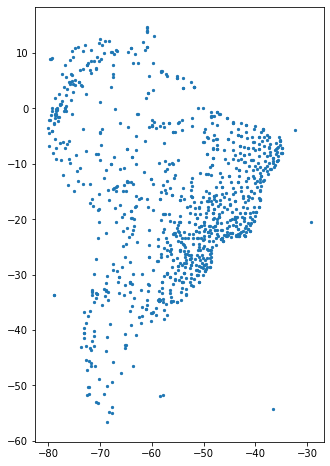

In [6]:
# compute latitude/longitude as a Point object
daily_data['geometry'] = daily_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# simple plot
gdf = gpd.GeoDataFrame(daily_data, geometry='geometry', crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(15, 8))
gdf.plot(ax=ax, markersize=5)
plt.show()
plt.close()

# Opening topography file

You can use another topography file, the final topo array must be in meters unit


Checking boundaries:
    expected domain: [-80, -25, -60, 15]
    lats: (-60.0, 15.0)
    lons: (-80.0, -25.0)
    
CPU times: user 3.42 s, sys: 182 ms, total: 3.6 s
Wall time: 3.6 s


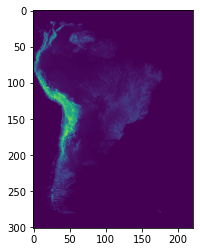

In [7]:
%%time
TOPO_PATHFILE = 'static/ETOPO2v2g_f4_0p01_origin.nc'

if NC_ENGINE in ['netcdf4']:

    #opening topography file
    nc = Dataset(TOPO_PATHFILE, 'r')

    # get coords
    lats_ = nc.variables['y'][:]
    lons_ = nc.variables['x'][:]

    # find closest index in topography file
    bounds_lon_idx = list(map(lambda coord: np.argmin(np.abs(coord-lons_)), DOMAIN[:2]))
    bounds_lat_idx = list(map(lambda coord: np.argmin(np.abs(coord-lats_)), DOMAIN[2:]))

    # lat and lon id bounds into a single list
    domain_idx = bounds_lon_idx + bounds_lat_idx
    # print(domain_idx)

    # ensure close interval on right side
    for bound_id, max_idx in zip([1, 3], [len(lons_), len(lats_)]):
        if domain_idx[bound_id] < max_idx:
            domain_idx[bound_id] += 1    


    # open topo only in specified domain
    topo = nc.variables['z'][domain_idx[2]:domain_idx[3],
                             domain_idx[0]:domain_idx[1]]

    lats_ = lats_[domain_idx[2]:domain_idx[3]]
    lons_ = lons_[domain_idx[0]:domain_idx[1]]

    nc.close()

    # interpolate topo array to expected resolution
    grid_lon_m, grid_lat_m = np.meshgrid(grid_lon, grid_lat)  # final grid coords
    lon_m, lat_m = np.meshgrid(lons_, lats_)  # topo coords

    # set topography points
    topo_points = np.array([lat_m.ravel(), lon_m.ravel()]).T

    # interpol topo to interpolated field resolution
    topo = griddata(topo_points, topo.ravel(), (grid_lat_m, grid_lon_m), method='nearest')
    
elif NC_ENGINE in ['xarray']:
    
    ds = xr.open_dataset(TOPO_PATHFILE).sel(y=slice(grid_lat[0], grid_lat[-1]),
                                            x=slice(grid_lon[0], grid_lon[-1]))
    ds = ds.interp(y=grid_lat, x=grid_lon, method='nearest')
    topo = ds['z'].values
    lats_ = ds['y'].values
    lons_ = ds['x'].values
    
else:
    raise NotImplementedError(f"engine {NC_ENGINE} not implemented")
    
topo[topo < 0] = 0  # avoid negative altitudes
print(
    f"""
Checking boundaries:
    expected domain: {DOMAIN}
    lats: {lats_[0], lats_[-1]}
    lons: {lons_[0], lons_[-1]}
    """
     )

plt.imshow(topo[::-1])

# Uniform elevations functions

In [9]:
@np.vectorize
def alt2ground(arr, topo):
    '''
    reduce station data from elevation to sea level
    
    :param arr: np.array (1D)  - weather station temperature values
    :param topo: np.array (1D) - weather station elevation (in meters)
    '''
    return arr + LAPSE_RATE * (topo/1000)

@np.vectorize
def ground2alt(arr, topo):
    '''
    increse interpolation result to right elevation
    
    :param arr: np.array (2D)  - interpolated temperature values
    :param topo: np.array (2D) - topography grid array (in meters)
    '''
    return arr - LAPSE_RATE * (topo/1000)

# Applying interpol

In [12]:
interpolated_ds = {}

lats_ws = daily_data['latitude'].values
lons_ws = daily_data['longitude'].values
elevation_ws = daily_data['elevation'].values

for variable in VARIABLES:
    
    print(f"starting {variable} interpolation")
    values_ws = daily_data[variable].values
    
    if TEMPERATURE_VARS:
        values_ws = alt2ground(values_ws, elevation_ws)
        
    grid_x, grid_y, grid = interpolate_to_grid(lons_ws,
                                               lats_ws,
                                               values_ws,
                                               **interpol_kwargs)
    
    
    if TEMPERATURE_VARS:
        grid = ground2alt(grid, topo)
        
    interpolated_ds[variable] = grid
    
    print(f"{variable} interpolation done")

starting tmax interpolation
tmax interpolation done
starting tmin interpolation
tmin interpolation done


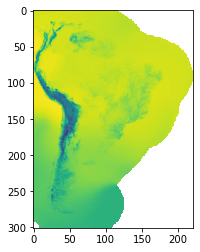

In [13]:
plt.imshow(interpolated_ds[variable][::-1])